In [1]:
from os import getcwd
from os.path import join, basename
from sys import path 

libs_dir = join("/".join(getcwd().split("/")[:-3]))
path.append(libs_dir)

filename = basename(globals()['__vsc_ipynb_file__']).split(".")[0]

import numpy as np
from libs.qchannel_model import *
import matplotlib.pyplot as plt
from libs.figure_config import *
from libs.default_parameters import *
from libs.simulation_tools import *
from qiskit_aer import AerSimulator
from libs.satellite import *

In [2]:
satellite_1293 = LEOsatellite(
    libs_dir + '/data/STARLINK_1293.txt')
location_aizu = np.loadtxt(
    libs_dir + '/data/ogs_loc.txt')
location_sendai = np.loadtxt(
    libs_dir + '/data/ogs_loc_sendai.txt')
year = 2021
day = 357
hour = 16
minute = 29

t = np.arange(0, 241, 10) 
second = 56 + t 
utc = 9

latitude_bob = location_aizu[:, 0]
longitude_bob = location_aizu[:, 1]
elevation_bob = location_aizu[:, 2]

latitude_alice = location_sendai[:, 0]
longitude_alice = location_sendai[:, 1]
elevation_alice = location_sendai[:, 2]

# Bob用のリスト
# Location: Sendai
slant_path_bob_lst = np.zeros(len(second))
zenith_angle_bob_lst = np.zeros(len(second))

# Alice用のリスト
# Location: Aizuwakamatsu
slant_path_alice_lst = np.zeros(len(second))
zenith_angle_alice_lst = np.zeros(len(second))

for idx in range(len(second)):
    # bobとの幾何学的関係を計算
    slant_path_bob_lst[idx], zenith_angle_bob_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_bob[0], latitude_bob[0], elevation_bob[0] # bobが単一の場合、[0]でアクセス
    )

    slant_path_alice_lst[idx], zenith_angle_alice_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_alice[0], latitude_alice[0], elevation_alice[0]
    )

slant_path_bob_lst = slant_path_bob_lst * 1000
slant_path_alice_lst = slant_path_alice_lst * 1000

print(f'zenith_angle_bob_lst: {zenith_angle_bob_lst}')
print(f'slant_path_bob_lst: {slant_path_bob_lst}')
print(f'zenith_angle_alice_lst: {zenith_angle_alice_lst}')
print(f'slant_path_alice_lst: {slant_path_alice_lst}')

zenith_angle_bob_lst: [59.12231128 56.36761957 53.29942595 49.86960124 46.02580343 41.71462467
 36.88795594 31.51443373 25.59889386 19.2177631  12.61487602  6.7674352
  6.48171328 12.17404931 18.77234156 25.17778075 31.12682233 36.53619297
 41.39769812 45.74103304 49.61362622 53.06877427 56.15900865 58.93278366
 61.43314946]
slant_path_bob_lst: [ 979281.42258988  922680.97578975  867989.73112258  815598.76854679
  765986.88542397  719735.33465974  677538.56068129  640204.25564149
  608632.69658226  583763.70863815  566483.96165212  557501.89981092
  557220.26202089  565652.39207484  582419.34676989  606829.16232343
  638002.9461296   675001.26380245  716919.39015494  762942.80649328
  812369.62519035  864611.54802037  919183.59014886  975689.46630056
 1033806.52269261]
zenith_angle_alice_lst: [59.82220731 57.20571    54.31536344 51.11731306 47.5796426  43.67872882
 39.41103877 34.81442487 30.00638313 25.25323752 21.08758441 18.41782064
 18.22698246 20.60210441 24.62188856 29.33180312 3

In [3]:
num_channel_coefficients = 5000 #100000
num_qubits_per_channel_coefficient = int(1e6)

tau_zen_lst = np.array([0.81, 0.75, 0.56])
# tau_zen_lst = np.array([0.81])
print(n_s)

1.0


In [4]:
backend = AerSimulator()

qber_simul =  np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))

In [5]:
tau_zen = 0.55
# zenith_angle_alice_deg = 59.82220731
# zenith_angle_bob_deg = 59.12231128
# slant_path_alice = 995551.87505841
# slant_path_bob = 979281.42258988

# zenith_angle_alice_deg = 25.253237515954822
# zenith_angle_bob_deg = 19.21776310316693
# slant_path_alice = 607471.4223632229
# slant_path_bob = 583763.7086381529

zenith_angle_alice_deg = 29.331803116796955
zenith_angle_bob_deg = 25.17778074899168
slant_path_alice = 628035.3654887656
slant_path_bob = 606829.1623234347

zenith_angle_alice_rad = np.radians(zenith_angle_alice_deg)
sigma_R_squared_alice = rytov_variance(
    wavelength, zenith_angle_alice_rad, h_OGS, h_atm, Cn2_profile)
w_L_alice = slant_path_alice * theta_rad
w_Leq_squared_alice = equivalent_beam_width_squared(a, w_L_alice)

# ボブ（Repeater）のパラメータ
zenith_angle_bob_rad = np.radians(zenith_angle_bob_deg)

sigma_R_squared_bob = rytov_variance(
    wavelength, zenith_angle_bob_rad, h_OGS, h_atm, Cn2_profile)
w_L_bob = slant_path_bob * theta_rad
w_Leq_squared_bob = equivalent_beam_width_squared(a, w_L_bob)

# --- 統計的な平均を取るためのループ ---
total_err_num = 0
total_sifted_bit_length = 0
for kdx in range(int(num_channel_coefficients)):
    print(f'回数: {kdx+1}')
            # --- ステップ1: アリスとボブの瞬時チャネル状態をそれぞれ計算 ---

    # アリス(User)の瞬時チャネル
    eta_ell_alice = compute_atm_loss(tau_zen, zenith_angle_alice_rad)
    eta_p_alice = rvs_pointing_err(
        mu_x, mu_y, sigma_theta_x, sigma_theta_y,
        slant_path_alice, theta_rad, a, w_Leq_squared_alice, size=1
    )[0]  # 配列から単一の値を抽出
    I_a_alice = rvs_LN_fading(sigma_R_squared_alice, size=1)[0]  # 配列から単一の値を抽出
    insta_eta_alice = eta_ell_alice * I_a_alice * eta_p_alice
    

    # ボブ(Repeater)の瞬時チャネル
    eta_ell_bob = compute_atm_loss(tau_zen, zenith_angle_bob_rad)
    eta_p_bob = rvs_pointing_err(
        mu_x, mu_y, sigma_theta_x, sigma_theta_y,
        slant_path_bob, theta_rad, a, w_Leq_squared_bob, size=1
    )[0]  # 配列から単一の値を抽出
    I_a_bob = rvs_LN_fading(sigma_R_squared_bob, size=1)[0]  # 配列から単一の値を抽出
    insta_eta_bob = eta_ell_bob * I_a_bob * eta_p_bob
    

    # --- ステップ2: 同時検出確率を計算 ---
    photon_probs = {}
    for i in range(10):
        photon_probs[f'p_{i}'] = photon_number_probability(i, lambda_signal)

    # 0~9までの確率をリストにまとめる
    prob_list = [photon_probs[f'p_{i}'] for i in range(10)]
    # 残りの確率をp_10として補完
    p_10 = 1.0 - sum(prob_list)
    prob_list.append(p_10)

    # 0~10のフォトン数に応じて10**6個のサンプルを生成
    photon_list = np.random.choice(range(11), size=10**6, p=prob_list)
    unique, counts = np.unique(photon_list, return_counts=True)
    photon_counts = dict(zip(unique, counts))
    # photon_counts のキーを int に変換してアクセス
    num_detected_event = 0
    count = [0] * 11
    for i in range(11):
        count[i] = int(photon_counts.get(np.int64(i), 0))
    # ここまでOK
    
    # アリスとボブのパウリゲート適用確率
    alice_pauli_probability = 0
    bob_pauli_probability = 0
    part_ka = []
    part_kb = []
    err_num = 0
    total_err_num = 0
    total_sifted_bit_length = 0
    
                
    for i in range(11):
        if int(photon_counts.get(np.int64(i), 0)) == 0:
            continue
        num_detected_event = 0
        yield_val = yield_from_photon_number(i, Y0_A, Y0_B, insta_eta_alice, insta_eta_bob)
        for _ in range(count[i]):
            if np.random.rand() < yield_val:
                num_detected_event += 1

        # パウリゲート適用確率を計算
        bob_pauli_probability = pauli_x_application_probability_bob(i, e_0, e_d, yield_val, insta_eta_alice, insta_eta_bob)
        # print(f'No. Detected event: {num_detected_event}')
        if (num_detected_event % 2 != 0):
            num_detected_event = num_detected_event - 1
        print(f'No. Detected event (even): {num_detected_event}')
        # 量子鍵生成
        if (num_detected_event != 0):
            part_ka, part_kb, err_num = generate_Siftedkey(
                num_detected_event,
                alice_pauli_probability,  # すでにスカラー値
                bob_pauli_probability,    # すでにスカラー値
                backend
            )
            total_err_num += err_num
            total_sifted_bit_length += len(part_ka)
            
# 統計的な平均を計算
if total_sifted_bit_length == 0:
    avg_qber = float('nan')
else:
    avg_qber = total_err_num / total_sifted_bit_length
print(f'Average QBER: {avg_qber*100:.4f}% (tau_zen: {tau_zen}, zenith_angle_alice: {zenith_angle_alice_deg})')

回数: 1
No. Detected event (even): 0
No. Detected event (even): 34
No. Detected event (even): 42
No. Detected event (even): 58
No. Detected event (even): 36
No. Detected event (even): 16
No. Detected event (even): 8
No. Detected event (even): 6
No. Detected event (even): 0
No. Detected event (even): 0
No. Detected event (even): 0
回数: 2
No. Detected event (even): 0
No. Detected event (even): 60
No. Detected event (even): 156
No. Detected event (even): 140
No. Detected event (even): 102
No. Detected event (even): 66
No. Detected event (even): 46
No. Detected event (even): 24
No. Detected event (even): 8
No. Detected event (even): 4
No. Detected event (even): 4
回数: 3
No. Detected event (even): 0
No. Detected event (even): 36
No. Detected event (even): 64
No. Detected event (even): 62
No. Detected event (even): 52
No. Detected event (even): 42
No. Detected event (even): 22
No. Detected event (even): 8
No. Detected event (even): 8
No. Detected event (even): 2
No. Detected event (even): 0
回数: 

In [1]:
for idx in range(len(tau_zen_lst)):
    tau_zen = tau_zen_lst[idx]
    print(f'tau_zen = {tau_zen}')
    
    
    for jdx in range(len(zenith_angle_alice_lst)):
        print(f'zenith_angle_alice = {zenith_angle_alice_lst[jdx]}')
        zenith_angle_alice_deg = zenith_angle_alice_lst[jdx]
        zenith_angle_alice_rad = np.radians(zenith_angle_alice_deg)
        slant_path_alice = slant_path_alice_lst[jdx] # アリスの距離
        sigma_R_squared_alice = rytov_variance(
            wavelength, zenith_angle_alice_rad, h_OGS, h_atm, Cn2_profile)
        w_L_alice = slant_path_alice * theta_rad
        w_Leq_squared_alice = equivalent_beam_width_squared(a, w_L_alice)

        # ボブ（Repeater）のパラメータ
        zenith_angle_bob_deg = zenith_angle_bob_lst[jdx]
        zenith_angle_bob_rad = np.radians(zenith_angle_bob_deg)
        slant_path_bob = slant_path_bob_lst[jdx] # ボブの距離
        sigma_R_squared_bob = rytov_variance(
            wavelength, zenith_angle_bob_rad, h_OGS, h_atm, Cn2_profile)
        w_L_bob = slant_path_bob * theta_rad
        w_Leq_squared_bob = equivalent_beam_width_squared(a, w_L_bob)
        
        # --- 統計的な平均を取るためのループ ---
        total_err_num = 0
        total_sifted_bit_length = 0
        
        
        for kdx in range(int(num_channel_coefficients)):
            # --- ステップ1: アリスとボブの瞬時チャネル状態をそれぞれ計算 ---

            # アリス(User)の瞬時チャネル
            eta_ell_alice = compute_atm_loss(tau_zen, zenith_angle_alice_rad)
            eta_p_alice = rvs_pointing_err(
                mu_x, mu_y, sigma_theta_x, sigma_theta_y,
                slant_path_alice, theta_rad, a, w_Leq_squared_alice, size=1
            )[0]  # 配列から単一の値を抽出
            I_a_alice = rvs_LN_fading(sigma_R_squared_alice, size=1)[0]  # 配列から単一の値を抽出
            insta_eta_alice = eta_ell_alice * I_a_alice * eta_p_alice
            

            # ボブ(Repeater)の瞬時チャネル
            eta_ell_bob = compute_atm_loss(tau_zen, zenith_angle_bob_rad)
            eta_p_bob = rvs_pointing_err(
                mu_x, mu_y, sigma_theta_x, sigma_theta_y,
                slant_path_bob, theta_rad, a, w_Leq_squared_bob, size=1
            )[0]  # 配列から単一の値を抽出
            I_a_bob = rvs_LN_fading(sigma_R_squared_bob, size=1)[0]  # 配列から単一の値を抽出
            insta_eta_bob = eta_ell_bob * I_a_bob * eta_p_bob
            

            # --- ステップ2: 同時検出確率を計算 ---
            photon_probs = {}
            for i in range(10):
                photon_probs[f'p_{i}'] = photon_number_probability(i, lambda_signal)

            # 0~9までの確率をリストにまとめる
            prob_list = [photon_probs[f'p_{i}'] for i in range(10)]
            # 残りの確率をp_10として補完
            p_10 = 1.0 - sum(prob_list)
            prob_list.append(p_10)

            # 0~10のフォトン数に応じて10**6個のサンプルを生成
            photon_list = np.random.choice(range(11), size=50**5, p=prob_list)
            unique, counts = np.unique(photon_list, return_counts=True)
            photon_counts = dict(zip(unique, counts))
            # photon_counts のキーを int に変換してアクセス
            num_detected_event = 0
            count = [0] * 11
            for i in range(11):
                count[i] = int(photon_counts.get(np.int64(i), 0))
            # ここまでOK
            
            # アリスとボブのパウリゲート適用確率
            alice_pauli_probability = 0
            bob_pauli_probability = 0
            part_ka = []
            part_kb = []
            err_num = 0
            total_err_num = 0
            total_sifted_bit_length = 0
            
                        
            for i in range(11):
                if int(photon_counts.get(np.int64(i), 0)) == 0:
                    continue
                num_detected_event = 0
                yield_val = yield_from_photon_number(i, Y0_A, Y0_B, insta_eta_alice, insta_eta_bob)
                for _ in range(count[i]):
                    if np.random.rand() < yield_val:
                        num_detected_event += 1

                # パウリゲート適用確率を計算
                bob_pauli_probability = pauli_x_application_probability_bob(i, e_0, e_d, yield_val, insta_eta_alice, insta_eta_bob)
                # print(f'No. Detected event: {num_detected_event}')
                if (num_detected_event % 2 != 0):
                    num_detected_event = num_detected_event - 1
                print(f'No. Detected event (even): {num_detected_event}')
                # 量子鍵生成
                if (num_detected_event != 0):
                    part_ka, part_kb, err_num = generate_Siftedkey(
                        num_detected_event,
                        alice_pauli_probability,  # すでにスカラー値
                        bob_pauli_probability,    # すでにスカラー値
                        backend
                    )
                    total_err_num += err_num
                    total_sifted_bit_length += len(part_ka)
            
        # 統計的な平均を計算
        if total_sifted_bit_length == 0:
            avg_qber = float('nan')
        else:
            avg_qber = total_err_num / total_sifted_bit_length
        qber_simul[idx][jdx] = avg_qber
        print(f'Average QBER: {avg_qber} (tau_zen: {tau_zen}, zenith_angle_alice: {zenith_angle_alice_deg})')
           

NameError: name 'tau_zen_lst' is not defined

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

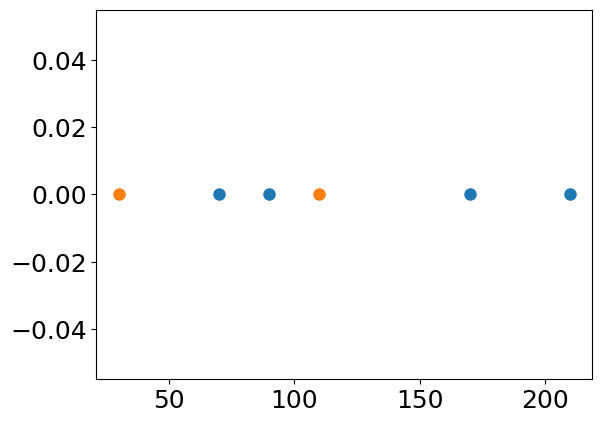

In [6]:
plt.scatter(t, qber_simul[0][:]*100)
plt.scatter(t, qber_simul[1][:]*100)
plt.scatter(t, qber_simul[2][:]*100)

In [12]:
np.save('results/qber_simul_bbm92_test1_8', qber_simul)

In [13]:
skr_values =  np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))

In [16]:
# for idx in range(len(tau_zen_lst)):
#     tau_zen = tau_zen_lst[idx]
#     for jdx in range(len(zenith_angle_alice_lst)):
#         zenith_angle_deg = zenith_angle_lst[jdx]
#         zenith_angle_rad = np.radians(zenith_angle_deg)
        
#         w_L = slant_path_lst[jdx] * theta_rad

#         _, yield_values= compute_avg_qber(
#             sigma_theta_x, sigma_theta_y, slant_path_lst[jdx], mu_x, mu_y,
#             zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
#             a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
#         )
        

#         Q_1, e_1 = compute_Q_1_e_1_ex(
#             sigma_theta_x, sigma_theta_y, slant_path_lst[jdx], mu_x, mu_y,
#             zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
#             a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
#         )

#         skr_values[idx][jdx] = compute_SKR(
#             qber_simul[idx][jdx], yield_values, Q_1, e_1
#         )
qber_simul = np.load('results/qber_simul_bbm92_test1_8.npy')
for idx in range(len(tau_zen_lst)):
    tau_zen = tau_zen_lst[idx]
    for jdx in range(len(zenith_angle_alice_lst)):
        
        # --- アリスとボブの平均チャネル性能を計算 ---
        # w_Lをそれぞれ計算
        w_L_alice = slant_path_alice_lst[jdx] * theta_rad
        w_L_bob = slant_path_bob_lst[jdx] * theta_rad

        # アリスの性能
        _, yield_alice = compute_avg_qber(
            sigma_theta_x, sigma_theta_y, slant_path_alice_lst[jdx], mu_x, mu_y,
            np.radians(zenith_angle_alice_lst[jdx]), h_OGS, h_atm, w_L_alice, tau_zen, Cn2_profile,
            a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
        )
        
        # ボブの性能
        _, yield_bob = compute_avg_qber(
            sigma_theta_x, sigma_theta_y, slant_path_bob_lst[jdx], mu_x, mu_y,
            np.radians(zenith_angle_bob_lst[jdx]), h_OGS, h_atm, w_L_bob, tau_zen, Cn2_profile,
            a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
        )
        yield_system = yield_alice * yield_bob
        
        skr_values[idx][jdx] = compute_SKR_final(
            qber_system=qber_simul[idx][jdx], # 計算したシステムQBER
            yield_alice=yield_alice,         # 計算したアリスのYield
            yield_bob=yield_bob,           # 計算したボブのYield
            f_ec=1.0,
            rep_rate=1e9
        )

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

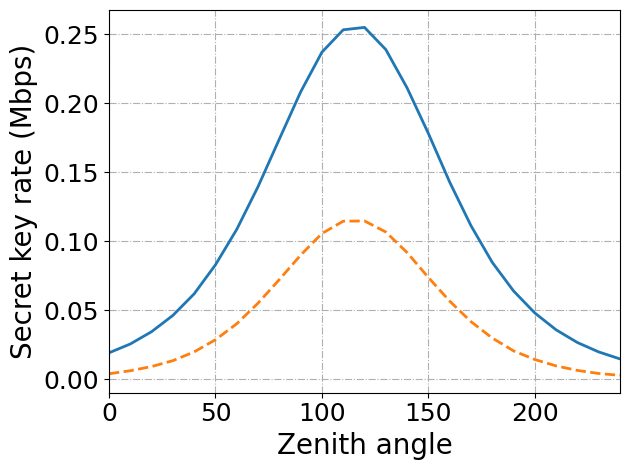

In [17]:
plt.plot(t, skr_values[0][:]/10**6)
plt.plot(t, skr_values[1][:]/10**6, ls='--')


plt.xlabel(r"Zenith angle")
plt.ylabel(r"Secret key rate (Mbps)")

plt.xlim(0, 240)

plt.grid()
plt.tight_layout()

In [9]:
np.save('results/skr_simul_bbm92_test1', skr_values)